## Use Benford's Law to idenfity vendor payments that might be fraudulent

In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# import data from .CSV files
files = glob.glob('data/cleaned_data/*.csv')

payments = pd.concat([pd.read_csv(f, dtype={'commitmt_item_name': 'str', 'dept._descrptn': 'str', 'vendor_name': 'str'}) \
                      for f in files], sort=True)

In [9]:
# glance at the data
payments.head()

,check/payment_date,commitmt_item_name,dept._descrptn,invoice_net_amt,vendor_name,leading_digit
0,2014-01-02,Inventories,Street Transportation,-34.78,3M COMPANY,-
1,2014-01-02,Inventories,Street Transportation,-69.55,3M COMPANY,-
2,2014-01-02,Inventories,Street Transportation,-77.00,3M COMPANY,-
3,2014-01-02,Inventories,Public Works,0.01,AGS SAFETY & SUPPLY,0
4,2014-01-02,Inventories,Police,-0.79,AMERICAN EUROCOPTER CORPORATION,-


In [44]:
# benford's law guidlines
benfords_law = pd.DataFrame(
    {'Leading_Digit':[1,2,3,4,5,6,7,8,9],
     'Benfords_Percent':[30.1,17.60,12.50,9.70,7.90,6.70,5.80,5.10,4.60]}
    )

In [45]:
benfords_law

,Leading_Digit,Benfords_Percent
0,1,30.1
1,2,17.6
2,3,12.5
3,4,9.7
4,5,7.9
5,6,6.7
6,7,5.8
7,8,5.1
8,9,4.6


In [4]:
# extract leading digit from vendor payments
payments['leading_digit'] = payments['invoice_net_amt'].apply(lambda x: str(x)[0])
# change data type of leading digit to int from string
vendor_leading_digit_percent['leading_digit'] = pd.to_numeric(vendor_leading_digit_percent.iloc[:,1])

In [5]:
# exclude payments with other than positive payment amounts
payments = payments[(payments['leading_digit'] != '-') &
         (payments['leading_digit'] != '0')]

In [6]:
# exclude vendors with less than 50 payments
at_least_50 = payments.groupby('vendor_name').filter(lambda x: x['invoice_net_amt'].count() >= 50)


In [21]:
# how many vendors have at least 50 payments
at_least_50['vendor_name'].nunique()

2286

In [92]:
# find the count of each leading digit for each vendor
vendor_leading_digit = at_least_50.groupby(['vendor_name', 'leading_digit']).size()
vendor_leading_digit.head(10)

vendor_name                    leading_digit
1 N 10 INC                     1                46
                               2                 8
                               3                 3
                               4                43
                               5                 5
                               6                 3
                               7                 1
                               9                 3
1 STOP ELECTRONICS CENTER INC  1                79
                               2                54
dtype: int64

In [9]:
# find the percent of total leading digits that each digit makes up
vendor_leading_digit_percent = vendor_leading_digit.groupby(level=0) \
    .apply(lambda x: 100 * x / float(x.sum())).reset_index()

In [11]:
# glance at the data
vendor_leading_digit_percent.head()

,vendor_name,leading_digit,0
0,1 N 10 INC,1,41.071429
1,1 N 10 INC,2,7.142857
2,1 N 10 INC,3,2.678571
3,1 N 10 INC,4,38.392857
4,1 N 10 INC,5,4.464286


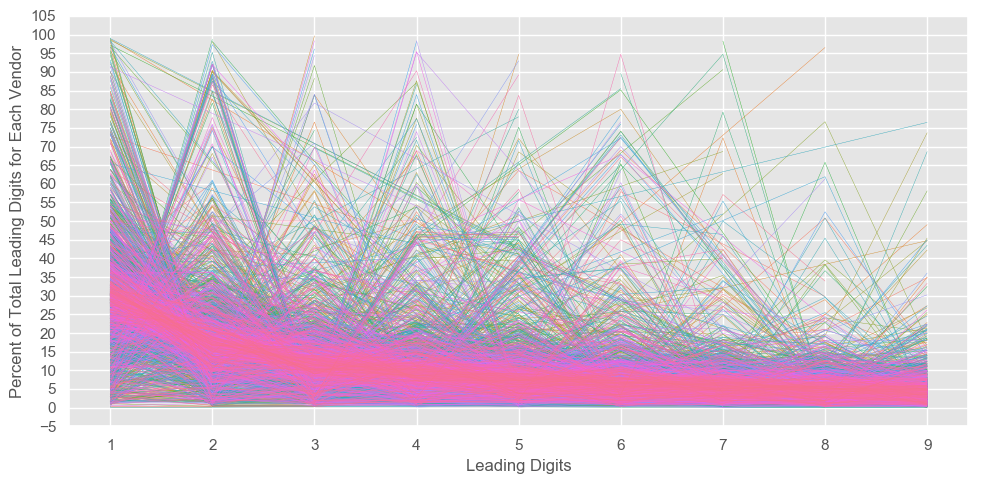

In [91]:
fig, ax = plt.subplots(figsize=(10,5))
plt.style.use('ggplot')
sns.set_context('notebook')

ax = sns.lineplot(x='leading_digit', \
                  y=vendor_leading_digit_percent.iloc[:,2], \
                  hue="vendor_name", \
                  data=vendor_leading_digit_percent, \
                  linewidth=.3, )

# plt.title("Leading Digit Frequencies for Vendors With At Least 50 Payments",fontsize=16)
plt.xlabel("Leading Digits")
plt.ylabel("Percent of Total Leading Digits for Each Vendor")
# plt.tick_params(labelsize=12)
ax.get_legend().remove()

ax.xaxis.set_major_locator(ticker.MultipleLocator())
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.tight_layout()

plt.savefig("visualizations/leading_digit_frequencies_for_vendors_with_at_least_50_payments.png")

### **Criteria for further filtering:**  
1. Vendors with a leading digit of 1 that is less than or equal to 20 percent of that vendors leading digits.  
1. Vendors with a leading digit of 9 that is greater than or equal to 10 percent of that vendors leading digits.  
1. Vendors with a leading digit of 2 that is less than or equal to 12 percent of that vendors leading digits.


In [13]:
# identify vendors if leading digit 1 is less than 20% of total digits for that vendor
# according to Benford's law, it should around 30%

vendor_leading_digit_percent['1_less_than_threshold'] = (vendor_leading_digit_percent['leading_digit'] == 1) & \
                                    (vendor_leading_digit_percent.iloc[:,2] <= 20)

# identify vendors if leading digit 9 is greater than or equal to 10% of total digits for that vendor
# according to Benford's law, it should be around 5%

vendor_leading_digit_percent['9_greater_than_threshold'] = (vendor_leading_digit_percent['leading_digit'] == 9) & \
                                    (vendor_leading_digit_percent.iloc[:,2] >= 10)

# identify vendors if leading digit 2 is greater than or equal to 12% of total digits for that vendor
# according to Benford's law, it should be around 18%

vendor_leading_digit_percent['2_less_than_threshold'] = (vendor_leading_digit_percent['leading_digit'] == 2) & \
                                    (vendor_leading_digit_percent.iloc[:,2] <= 12)

,vendor_name,leading_digit,0,1_less_than_threshold,9_greater_than_threshold,2_less_than_threshold
0,1 N 10 INC,1,41.071429,False,False,False
1,1 N 10 INC,2,7.142857,False,False,True
2,1 N 10 INC,3,2.678571,False,False,False
3,1 N 10 INC,4,38.392857,False,False,False
4,1 N 10 INC,5,4.464286,False,False,False


In [17]:
# identify outlyer vendors if all of the above criteria are true
anomaly_vendors = vendor_leading_digit_percent.groupby(['vendor_name']).filter(lambda x: any(x['1_less_than_threshold'] == True) &
                                                            any(x['9_greater_than_threshold'] == True) &
                                                            any(x['2_less_than_threshold'] == True))

In [29]:
# extract anomaly vendor names and form into a list 
anomaly_vendors_names = []
for group in anomaly_vendors.groupby(['vendor_name']).groups: 
    anomaly_vendors_names.append(group)

In [93]:
# how many anomaly vendors are there based on all three of the above criteria being true?
len(anomaly_vendors_names)

21

In [37]:
# subset leading digit data for only anomaly vendors
anomaly_vendors_data = vendor_leading_digit_percent[vendor_leading_digit_percent \
                                                    .vendor_name.isin(anomaly_vendors_names)]

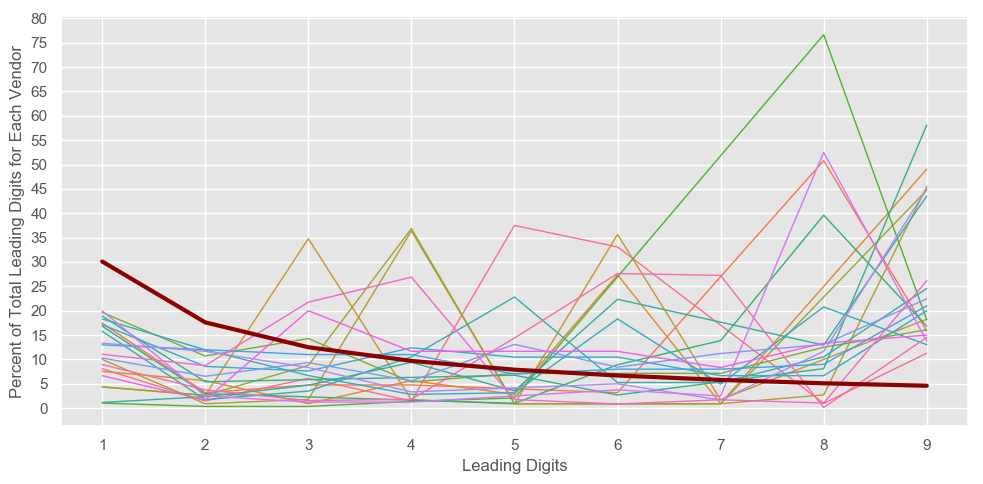

In [90]:
# plot subset data with benfords law
fig, ax = plt.subplots(figsize=(10,5))
plt.style.use('ggplot')
sns.set_context('notebook')

ax = sns.lineplot(x=anomaly_vendors_data.iloc[:,1], \
                  y=anomaly_vendors_data.iloc[:,2], \
                  hue=anomaly_vendors_data.iloc[:,0], \
                  data=anomaly_vendors_data, \
                  linewidth=1, )

ax = sns.lineplot(x=benfords_law.iloc[:,0],
                 y=benfords_law.iloc[:,1],
                  linewidth=3,
                 color='darkred')

plt.xlabel("Leading Digits")
plt.ylabel("Percent of Total Leading Digits for Each Vendor")
# plt.tick_params(labelsize=12)
ax.get_legend().remove()

ax.xaxis.set_major_locator(ticker.MultipleLocator())
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.tight_layout()

plt.savefig("visualizations/Anomaly Vendors Based on Benford's Law.png")

### Summary:
1. The anomaly vendors clearly do not fit the red line representing Benford's Law guidlines. 
1. Many of them have an unusually hight percentage of the digit 9.  Maybe in the future I should provide a range
for instance, 9s that make up more than 10 percent, but less than 20 percent.
1. For many, it seems that if the digit 1 makes up a smaller percent(less than 20%), another digit takes up the slack 
with a high percent, rather than all digits being equally distributed, as I was expecting.

In [94]:
anomaly_vendors_names

['ABSOLUTE STANDARDS',
 'AIRPORT WILDLIFE CONSULTANTS LLC',
 'APCO INTERNATIONAL INC',
 'BALLARD SPAHR LLP',
 'CITY OF PHOENIX FOOTHILLS ON THE',
 'CITY OF PHOENIX RED MOUNTAIN SPRING',
 'COMMUNITY BRIDGES INC',
 'CRAWFORD AND COMPANY',
 'CYBERTECH SYSTEMS & SOFTWARE INC',
 'DIAZ, OTILIA M',
 'LANDCORP PROPERTY',
 'MARICOPA COUNTY',
 'MULTI-CULTURAL BOOKS & VIDEOS',
 'PETTY CASH HSD FAMILY ADVOCACY CTR',
 'PETTY CASH PW ADMIN FISCAL',
 'PETTY CASH STREET TRANS-MGMT SRVC',
 'PH&S PRODUCTS LLC',
 'PIBHC MARCOS DE NIZA LLC',
 'SOLAR STAR ARIZONA VI LLC',
 'THYSSENKRUPP ELEVATOR CORP',
 'TRELLIS']